# Vamos a importar los datos de Kaggle a este Colab



In [1]:
!pip install opendatasets
import opendatasets as od

In [2]:
dataset_link = "https://www.kaggle.com/competitions/mpdb-20232024-deep-learning-assignment"
od.download(dataset_link)

Skipping, found downloaded files in "./mpdb-20232024-deep-learning-assignment" (use force=True to force download)


Aquí nos va a pedir nuestro usuario de kaggle y nuestra clave, que no es la contraseña. Para conseguir la clave, hay que irse al usuario de kaggle -> settings -> API -> create new token y nos descargara un json donde viene nuestro kaggle key, copiamos y pegamos aquí y se nos descarga el dataset de la competición

# Aquí empieza la práctica

In [3]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

Esto es para cargar los datos, nos lo da el profesor.

In [4]:
TRN_IMAGES = '/content/mpdb-20232024-deep-learning-assignment/train'
VLD_IMAGES = '/content/mpdb-20232024-deep-learning-assignment/validation'
TST_IMAGES = '/content/mpdb-20232024-deep-learning-assignment/test'

In [5]:
label_chars = '0123456789aeu'
chars_to_int = {c: i for i, c in enumerate(label_chars)}
int_to_chars = {i: c for i, c in enumerate(label_chars)}

In [6]:
def load_dataset(path):
    model_input, model_output = [], []

    # Cargamos el CSV del conjunto. Tenemos suerte y se llama
    # igual que el directorio, así que podemos hacer esto
    csv_path = f'{path}.csv'
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        df = None

    # Vamos leyendo las imágenes y cogiendo la label de cada
    # imagen
    for image_path in sorted(glob.glob(f'{path}/*.png')):
        # Cargamos la imagen, le hacemos todas las modificaciones
        # que queramos y la guardamos como array de numpy
        with Image.open(image_path) as image:
            model_input.append(np.array(image))

        # Si tenemos csv asociado, cargamos su label
        if df is not None:
            filename = os.path.basename(image_path)
            idname = int(os.path.splitext(filename)[0])
            label = df.loc[df['Id'] == idname]['Label'].item()
            # Para poder usar cada caracter como salida de mi modelo
            # tengo que pasarlos a enteros (así puedo usar sparse
            # categorical cross entropy). También puedo pasarlo a la
            # codificación one-hot y luego en el compile usar un
            # categorical cross entropy normal, pero así ocupamos menos
            # memoria
            label_as_ints = [
                chars_to_int[char]
                for char in label
            ]
            model_output.append(label_as_ints)

    return np.array(model_input), np.array(model_output)

Empieza nuestro modelo

In [7]:
x_trn, y_trn = load_dataset(TRN_IMAGES)
x_vld, y_vld = load_dataset(VLD_IMAGES)
x_tst, _ = load_dataset(TST_IMAGES)

print(f'X train shape:      {x_trn.shape},\tY train shape: {y_trn.shape}')
print(f'X validation shape: {x_vld.shape},\tY validation shape: {y_vld.shape}')
print(f'X test shape:       {x_tst.shape}')

X train shape:      (10000, 160, 400, 3),	Y train shape: (10000, 6)
X validation shape: (1000, 160, 400, 3),	Y validation shape: (1000, 6)
X test shape:       (2500, 160, 400, 3)


Text(0.5, 1.0, '[6 8 0 3 0 4]')

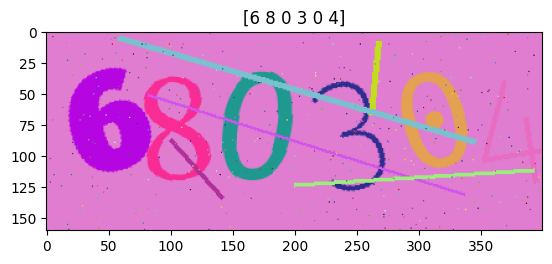

In [ ]:
IMAGE_ID = 0

plt.imshow(x_trn[IMAGE_ID])
plt.title(str(y_trn[IMAGE_ID]))

In [27]:
# Preprocesamiento de mis datos de entrenamiento, validación y test con cv2 de OpenCV

import cv2

def preprocess_images(images):
    processed_images = []
    for img in images:
        # Convertimos a escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Aplicamos filtrado de mediana para eliminar el ruido impulsivo
        denoised = cv2.medianBlur(gray, 3)  # Ajustado al tamaño del kernel

        # Aplicamos ecualización del histograma para mejorar el contraste
        equalized = cv2.equalizeHist(denoised)

        # Aplicamos umbralización adaptativa para distinguir los números del fondo de la imagen
        binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 1)

        # Invertimos los colores
        binary = cv2.bitwise_not(binary)

        # Redimensionamos la imagen a tamaños 200x80
        resized = cv2.resize(binary, (200, 80))

        # Normalizamos los valores de píxeles entre 0 y 1 para que aprenda mejor la red
        normalized = resized / 255.0

        # Agregamos la imagen preprocesada a la lista de imágenes procesadas
        processed_images.append(normalized)

    return np.array(processed_images)

# Aplicamos preprocesamiento a nuestros sets
x_trn_processed = preprocess_images(x_trn)
x_vld_processed = preprocess_images(x_vld)
x_tst_processed = preprocess_images(x_tst)

In [28]:
x_trn_processed.shape

(10000, 80, 200)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80, 200, 1)]         0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 78, 198, 16)          160       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 39, 99, 16)           0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 37, 97, 32)           4640      ['max_pooling2d_4[0][0]'

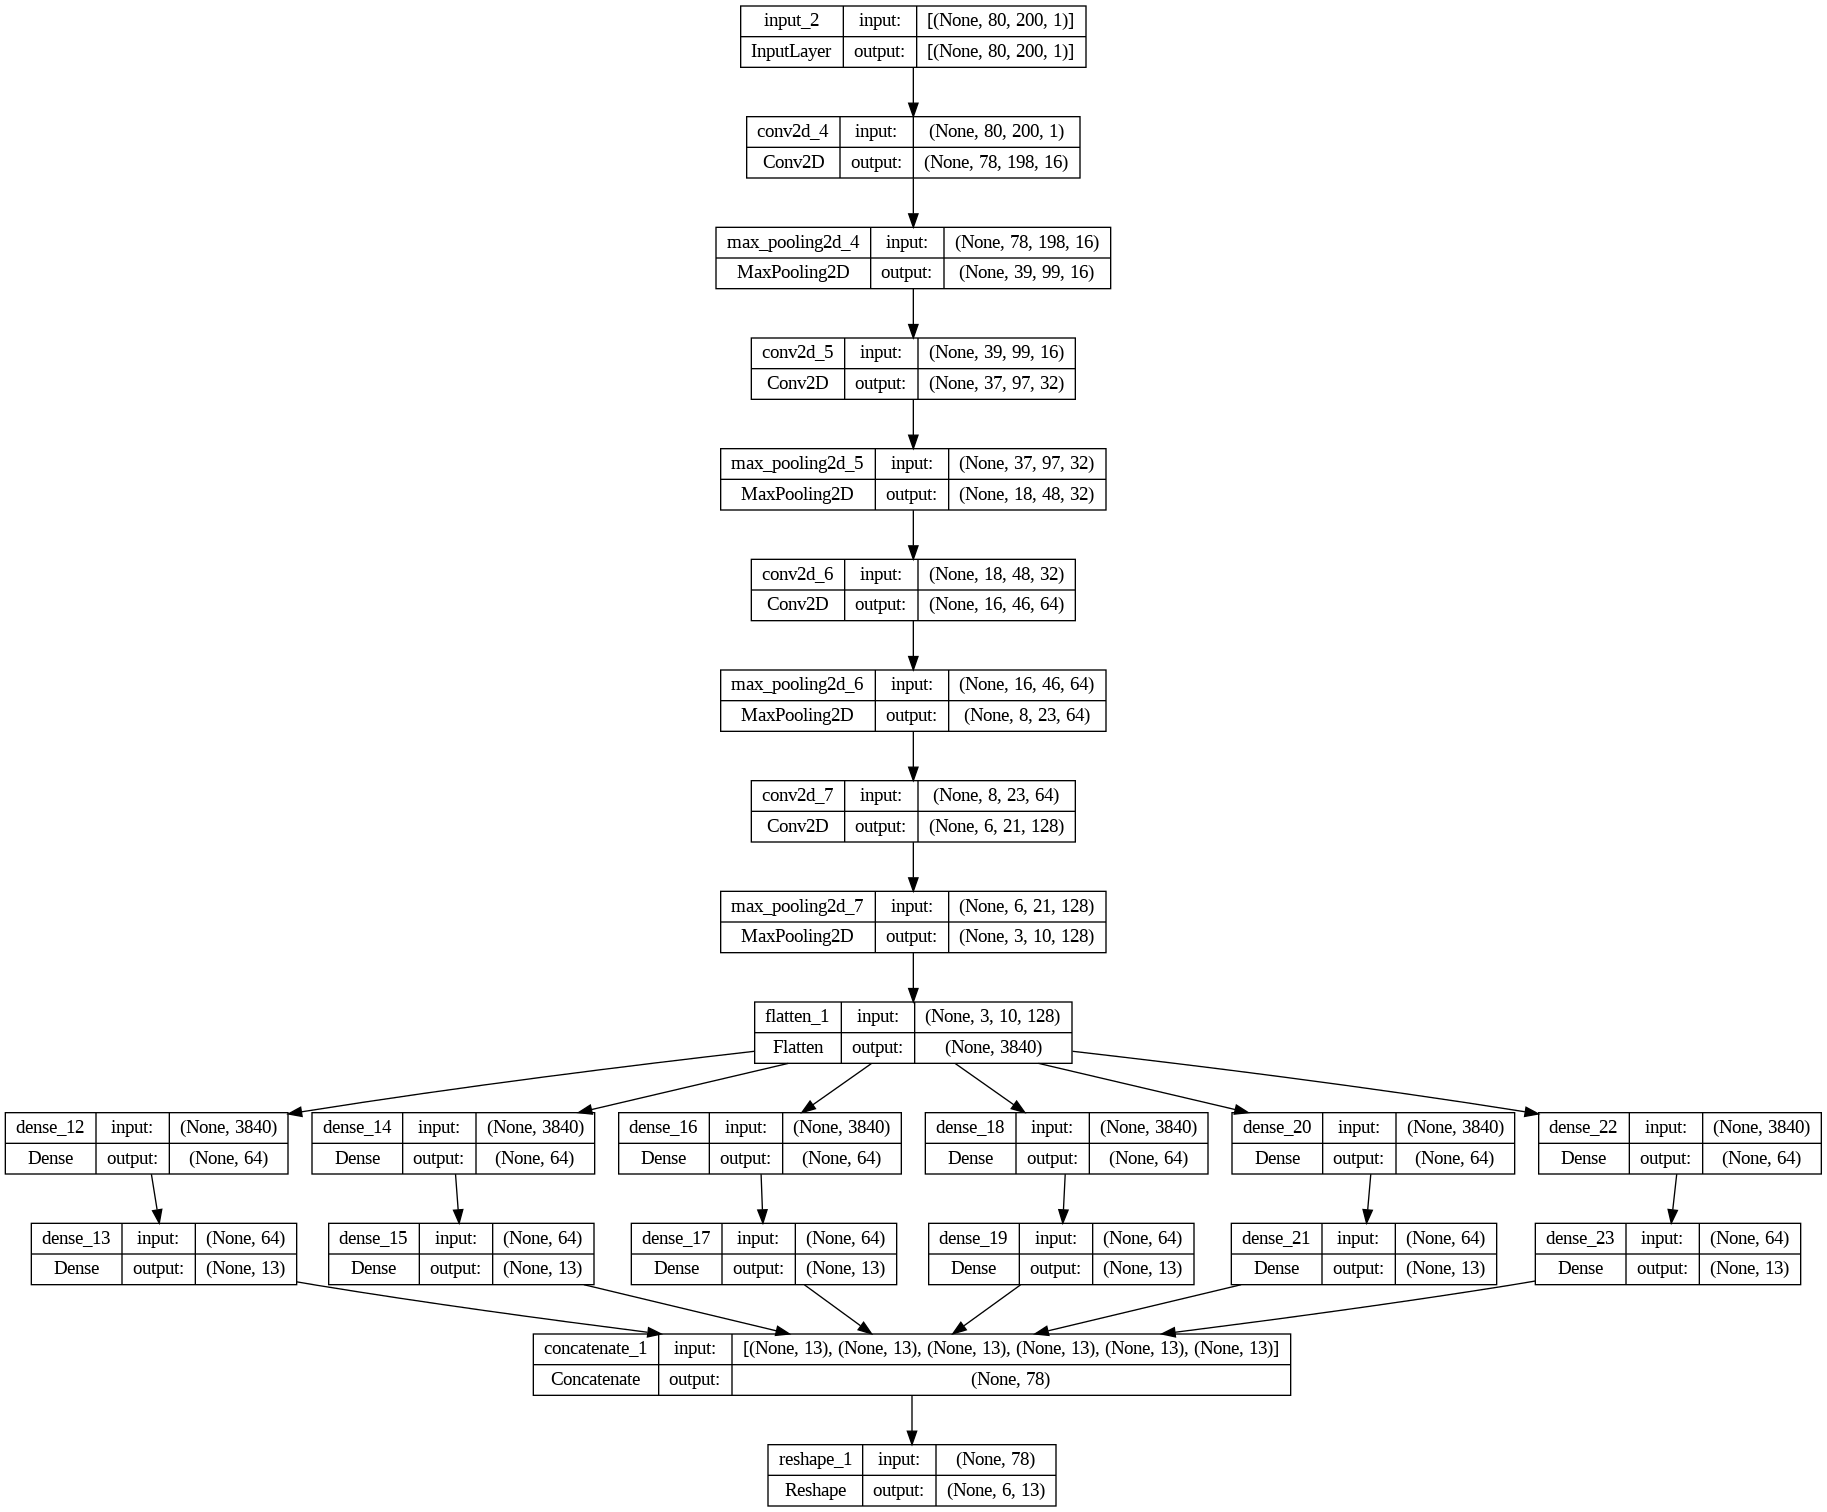

In [29]:
# Modelo

model_input = tf.keras.layers.Input(shape = (80, 200, 1))

hidden = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu')(model_input)
hidden = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(hidden)

hidden = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(hidden)
hidden = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(hidden)

hidden = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(hidden)
hidden = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(hidden)

hidden = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')(hidden)
hidden = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(hidden)

hidden = tf.keras.layers.Flatten()(hidden)

model_outputs = []

for i in range(1,7):

  out_1 = tf.keras.layers.Dense(64, activation = 'relu')(hidden)
  drop = tf.keras.layers.Dropout(0.5)(out_1)
  out_2 = tf.keras.layers.Dense(13, activation = 'sigmoid')(out_1)

  model_outputs.append(out_2)

model_output = tf.keras.layers.Concatenate()(model_outputs)
model_output = tf.keras.layers.Reshape((6, 13))(model_output)

model = tf.keras.Model(model_input, model_output)
model.summary()
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

In [30]:
#Compilación

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [31]:
history = model.fit(x_trn_processed, y_trn, epochs = 50, validation_data = (x_vld_processed, y_vld))

Epoch 1/50
313/313 [==============================] - 9s 15ms/step - loss: 1.8594 - sparse_categorical_accuracy: 0.3475 - val_loss: 0.9955 - val_sparse_categorical_accuracy: 0.6643
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 0.6577 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.5182 - val_sparse_categorical_accuracy: 0.8295
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 0.3660 - sparse_categorical_accuracy: 0.8819 - val_loss: 0.4219 - val_sparse_categorical_accuracy: 0.8695
Epoch 4/50
313/313 [==============================] - 4s 14ms/step - loss: 0.2313 - sparse_categorical_accuracy: 0.9254 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.8823
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.9504 - val_loss: 0.3786 - val_sparse_categorical_accuracy: 0.8883
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 0.1090 - sparse_cate

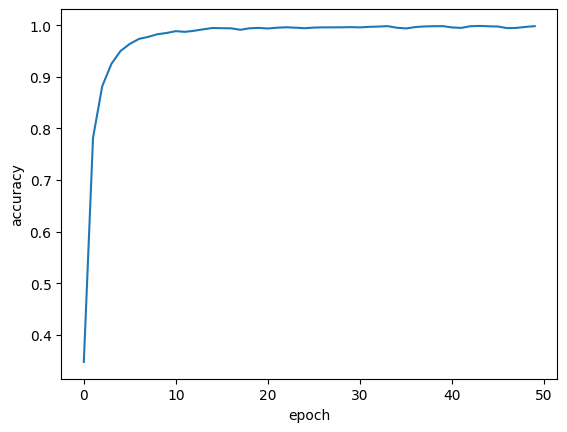

In [32]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [33]:
predictions = model.predict(x_tst_processed)
predictions[:1]

79/79 [==============================] - 0s 4ms/step


array([[[8.0718689e-14, 1.4042806e-19, 9.9725431e-01, 2.5880308e-11,
         1.5365066e-16, 1.5779029e-15, 4.1500838e-18, 1.1121705e-08,
         4.5582323e-12, 6.2214644e-07, 2.4585292e-14, 9.2393407e-19,
         7.9803914e-24],
        [4.9662910e-21, 5.5433607e-22, 7.0868071e-26, 3.7197194e-15,
         2.8087012e-08, 1.3066382e-12, 2.1247967e-10, 5.0346483e-24,
         5.0050642e-16, 1.8833973e-12, 8.2634762e-07, 9.9989545e-01,
         1.5393689e-17],
        [1.1311490e-07, 2.1203035e-17, 2.4628810e-17, 1.5860594e-18,
         1.8227977e-22, 3.8504983e-21, 5.0132295e-21, 2.3134950e-17,
         9.5466468e-25, 9.9988306e-01, 1.6676700e-14, 2.2401268e-25,
         2.1323449e-28],
        [1.1343332e-06, 1.5442259e-06, 5.0420712e-15, 1.8516791e-11,
         3.4060010e-10, 1.4203746e-13, 2.5904999e-15, 1.8535845e-10,
         6.9169459e-13, 3.9661666e-15, 2.8072813e-04, 7.5446871e-11,
         6.3729554e-01],
        [6.3583699e-10, 7.4934995e-08, 6.3870107e-24, 5.0109976e-19,
   

In [34]:
encoded_predictions = predictions.argmax(axis=-1)
encoded_predictions[:2]

array([[ 2, 11,  9, 12, 12,  9],
       [ 7,  8,  8,  0,  8,  0]])

In [35]:
labels = [
    ''.join([int_to_chars[i] for i in label])
    for label in encoded_predictions
]
labels[:10]

['2e9uu9',
 '788080',
 '109331',
 '325572',
 'e27915',
 '546647',
 '237143',
 '728663',
 '267168',
 '680150']

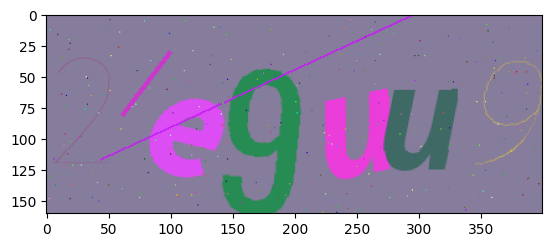

In [46]:
IMAGE_ID = 0
plt.imshow(x_tst[IMAGE_ID])

In [ ]:
# Ejemplo de como queda una imagen procesada

IMAGE_ID = 0

plt.imshow(x_trn_processed[IMAGE_ID])
plt.title(str(y_trn[IMAGE_ID]))

In [37]:
csv_content_2 = 'Id,Label\n'
for i, label in enumerate(labels):
    csv_content_2 += f'{i},{label}\n'

with open('outputs.csv', 'w') as f:
    f.write(csv_content_2)